In [70]:
# import libaraies

import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.transform import resize
import os

In [71]:
# set debug
# debug = True
debug = False

In [72]:
# name of the input file
# time on two small files first

imname = 'monastery.jpg' # another file to test: 'monastery.jpg', 'cathedral.jpg'

# test on tif
imname = 'media/self_portrait.tif' 
imname = 'media/harvesters.tif' 

In [73]:
# read in the image
im = skio.imread(imname)

In [74]:
# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)

if debug:
    print(im.shape)
    print(im * 255)

In [75]:
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

In [76]:
# separate color channels, by pics
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

def crop_edge(image):
    # set the [epsilon] that check if the pixel near black or white
    # set the [threshold] if the pixel that closer to black or white pass this [threshold], then we remove this col or row
    epsilon = 0.2
    threshold = 0.7
    
    # check if the pixel near white or black using [epsilon]
    pixel_close_to_white_black = (image <= epsilon) | (image >= 1 - epsilon)
    
    # calculate the num of the pixels that are close to white or black in each col and row
    count_row_near_white_black = np.sum(pixel_close_to_white_black, axis=1)
    count_col_near_white_black = np.sum(pixel_close_to_white_black, axis=0)
    
    # check which col and rows we want to reserve by using [threshold]
    rows_we_want = count_row_near_white_black < threshold * b.shape[1]
    
    cols_we_want = count_col_near_white_black < threshold * b.shape[0]
    # return the [cutted_image]
    return image
    return image[rows_we_want][:, cols_we_want]

In [77]:
if (debug):
    print(type(b)) # <class numpy.ndarray'>
    print("B: ", b, "G: ", g, "R", r) # b, g, r is a array

In [78]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

# failed to using the crop
if(debug):
    skio.imshow(im)
    print(im.shape)

if(debug):
    H, W = im.shape
    H = (H // 3) * 3  # let H could be divide by 3 to crop
    print("height of the image: ", H, "\nweight of the image: ", W)
    crop_im = np.array([im[:int(H/3), :], im[int(H/3):int(2*H/3), :], im[int(2*H/3):int(H), :]])
    skio.imshow(crop_im[0])
    skio.imshow(r)
    skio.imshow(b)
    # skio.imshow(g)

In [79]:
# define align function
# covert to uint8, unsigned integer
# Normalized cross-correlation (NCC) or Euclidean Distance or Structural Similarity (SSIM) Index to figure out how much we want to np.roll
# Euclidean Distance: sqrt(sum(sum((image1-image2).^2)))

# np.roll, np.sum, sk.transform.rescale (for multiscale)
# np.roll
# axis=0 y轴移动, axis=1 x轴移动

# we want to define a align function that align each pixel and make sure that the error is most small
# we want use np.roll function to manually align each pic in positive spaces, and calculate the error and find the smallest one as perfect align

# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
def eucliden_distance(image1, image2):
    return np.sqrt(np.sum((image1 - image2)**2))

def align_eucliden_distance_version(image1, image2, max_shift=15):
    smallest_error = float('inf') # set the smallest error as infinty
    best_shift = (0, 0)
    
    for x_shift in range(-max_shift, max_shift + 1):
        for y_shift in range(-max_shift, max_shift + 1):
            # shift both x and y axis
            image = np.roll(np.roll(image1, x_shift, axis=1), y_shift, axis=0)
            # calculate the error 
            distance = eucliden_distance(image, image2)
            # update the best pic position and smallest error
            if distance < smallest_error:
                best_shift = (x_shift, y_shift)
                smallest_error = distance
    best_image = np.roll(np.roll(image1, best_shift[0], axis=1), best_shift[1], axis=0)
    return best_image, best_shift

def ssim(image1, image2):
    return sk.metrics.structural_similarity(image1, image2, data_range=1)

def ssim_align(image1, image2, max_shift=15):
    smallest_error = 0
    best_shift = (0, 0)
    
    for x_shift in range(-max_shift, max_shift + 1):
        for y_shift in range(-max_shift, max_shift + 1):
            # shift both x and y axis
            image = np.roll(np.roll(image1, x_shift, axis=1), y_shift, axis=0)
            # calculate the error 
            distance = ssim(image, image2)
            # update the best pic position and smallest error
            if distance > smallest_error:
                best_shift = (x_shift, y_shift)
                smallest_error = distance
    best_image = np.roll(np.roll(image1, best_shift[0], axis=1), best_shift[1], axis=0)
    return best_image, best_shift

# use imresize to make the image smaller
def align(image1, image2, max_shift=15, min_size=64):
    # check if image is smaller than certain size; if image is as small as we want, then align_ssim
    if (image1.shape[0] < min_size) or (image1.shape[1] < min_size):
        # ssim_align
        return ssim_align(image1, image2, max_shift)
    # if the image is not as small as we want, then 
    else:
        # resize the both image, make the image smaller
        res_image1 = resize(image1, (image1.shape[0] // 2, image1.shape[1] // 2))
        res_image2 = resize(image2, (image1.shape[0] // 2, image1.shape[1] // 2))
        # send the image to func again, from the smallest image, we get the [image] and [shift]
        trash_image, smaller_shift = align(res_image1, res_image2, max_shift)
        # use the [shift] from the smaller pic, to get the [normal_shift] for the cur_image, and throw the [image] away
        shift = (smaller_shift[0] * 2, smaller_shift[1] * 2)
        # make the roll, based on the [normal_shift] to cur_image
        image = np.roll(np.roll(image1, shift[0], axis=1), shift[1], axis=0)
        # call ssim_align to align the image, get the [ret_image]
        ret_image, shift_after_align = ssim_align(image, image2, max_shift = 3)
        # calculate the [shift] we have so far
        ret_shift = (shift[0] + shift_after_align[0], shift[1] + shift_after_align[1])
        #ret
        return ret_image, ret_shift
    
if (debug):
    print([i for i in range(-15, 15 + 1)])
    print(np.roll(np.roll(r, -15, axis=1), 0, axis=0))

green offset:  (14, 59) 
red offset:  (11, 122)


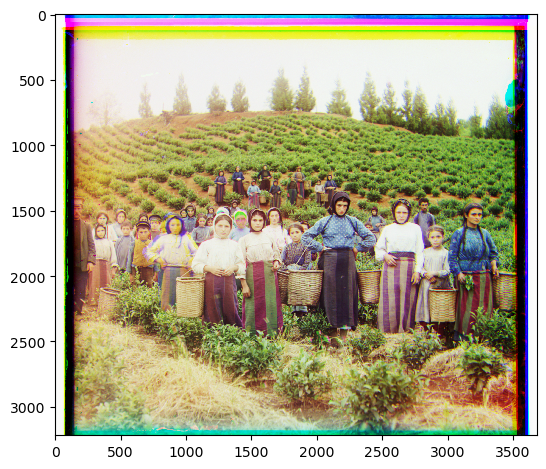

CPU times: user 1min 9s, sys: 28.3 s, total: 1min 37s
Wall time: 1min 55s


In [80]:
%%time

# result
ag, ag_offset = align(crop_edge(g), crop_edge(b))
ar, ar_offset = align(crop_edge(r), crop_edge(b))
print("green offset: ", ag_offset, "\nred offset: ", ar_offset)

def covert_to_uint8(data):
    return_me = data * 255
    return return_me.astype(np.uint8)

if(debug):
    print("date type for elements in ag, ar, b", type(ag[0][0]), type(ar[0][0]), type(b[0][0]))
    print("green offset: ", ag_offset, "\nred offset: ", ar_offset)

# create a color image
im_out = np.dstack([covert_to_uint8(ar), covert_to_uint8(ag), covert_to_uint8(crop_edge(b))]) # 堆叠数组，这里堆叠三个颜色

# save the image
fname = 'out_fname.jpg'
skio.imsave(fname, im_out)


# display the image
skio.imshow(im_out)
skio.show()